#Zasoby

* Scalable forecasting with millions of time-series in BigQuery

* https://cloud.google.com/bigquery/docs/e2e-journey
* https://cloud.google.com/bigquery/docs/arima-speed-up-tutorial
* https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-time-series

#Cele

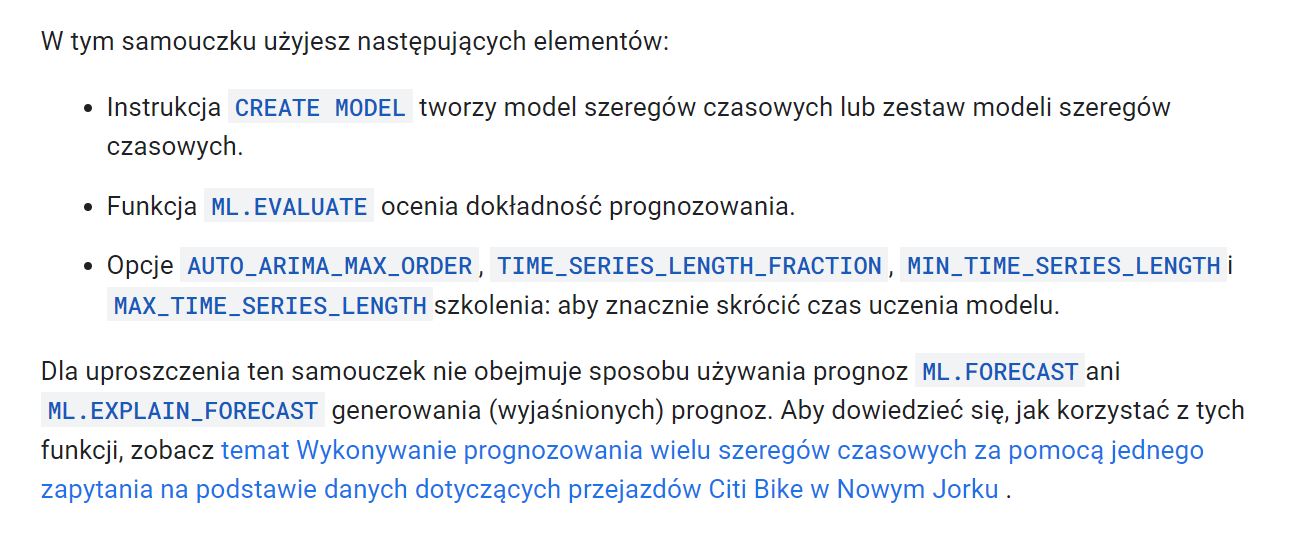

#Utwórz szereg czasowy do prognozowania (Krok 1)

##CREATE OR REPLACE TABLE

In [ ]:
%%bigquery

CREATE OR REPLACE TABLE
  pmackowka_us.table_0141 AS

WITH input_time_series AS
(
  SELECT
    start_station_name,
    EXTRACT(DATE FROM starttime) AS date,
    COUNT(*) AS num_trips
  FROM
    `bigquery-public-data`.new_york.citibike_trips
  GROUP BY
    start_station_name, date
)

SELECT table_1.*
FROM input_time_series AS table_1
INNER JOIN (
  SELECT start_station_name,  COUNT(*) AS num_points
  FROM input_time_series
  GROUP BY start_station_name) table_2
ON
  table_1.start_station_name = table_2.start_station_name
WHERE
  num_points > 400

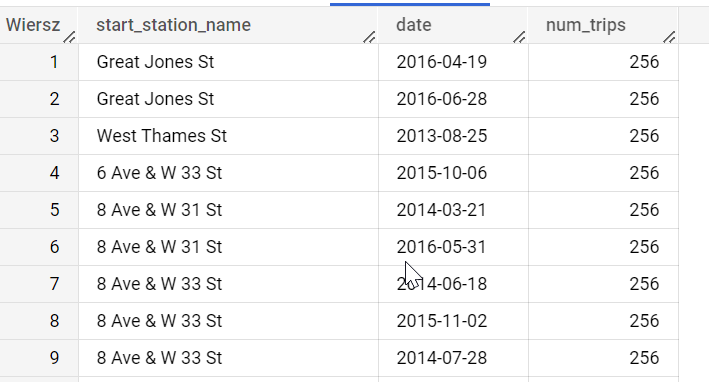

* Nie wiem po co powyższe zapytanie skoro dane są takie same jak dla poniższego zapytania

* Już wiem, ale po co takie kombinowanie? table_1 ma 679 szeregów czasowych. Zapytanie wykorzystuje dodatkową INNER JOIN logikę, aby wybrać wszystkie szeregi czasowe, które mają więcej niż 400 punktów czasowych, co daje w sumie 383 szeregi czasowe.

In [ ]:
%%bigquery

  SELECT
    start_station_name,
    EXTRACT(DATE FROM starttime) AS date,
    COUNT(*) AS num_trips
  FROM
    `bigquery-public-data`.new_york.citibike_trips
  GROUP BY
    start_station_name, date

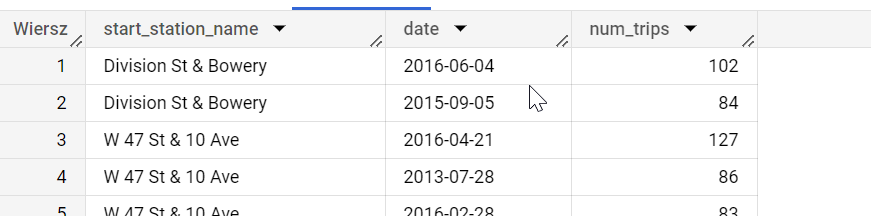

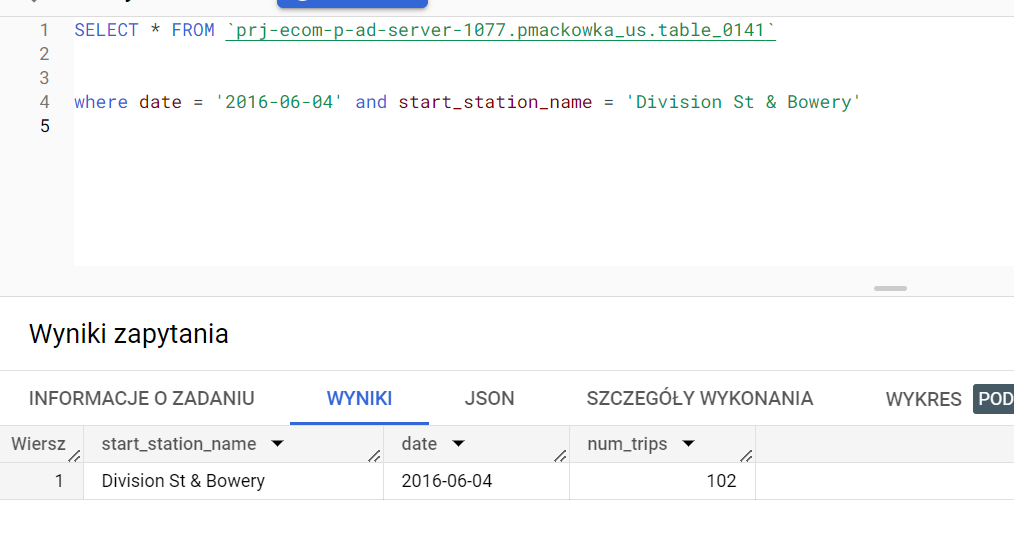

#Jednocześnie prognozuj wiele szeregów czasowych z parametrami domyślnymi (Krok 2)

##CREATE OR REPLACE MODEL

* Na tym etapie prognozujesz łączną dzienną liczbę przejazdów rozpoczynających się od różnych stacji Citi Bike. Aby to zrobić, należy prognozować wiele szeregów czasowych. Można napisać wiele `CREATE MODEL` zapytań, ale może to być żmudny i czasochłonny proces, szczególnie w przypadku dużej liczby szeregów czasowych.

* Aby usprawnić ten proces, `BigQuery ML` umożliwia utworzenie zestawu modeli szeregów czasowych w celu prognozowania wielu szeregów czasowych za pomocą jednego zapytania. Dodatkowo wszystkie modele szeregów czasowych pasują jednocześnie.
* W tym przykładzie pominięto punkty czasowe w szeregu czasowym po 2016-06-01, aby można było je później wykorzystać do oceny dokładności prognozowania za pomocą tej `ML.EVALUATE` funkcji.

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL pmackowka_us.model_0141
OPTIONS
  (model_type = 'ARIMA_PLUS',
   time_series_timestamp_col = 'date',
   time_series_data_col = 'num_trips',
   time_series_id_col = 'start_station_name'
  ) AS
SELECT *
FROM `pmackowka_us.table_0141`
WHERE date < '2016-06-01'

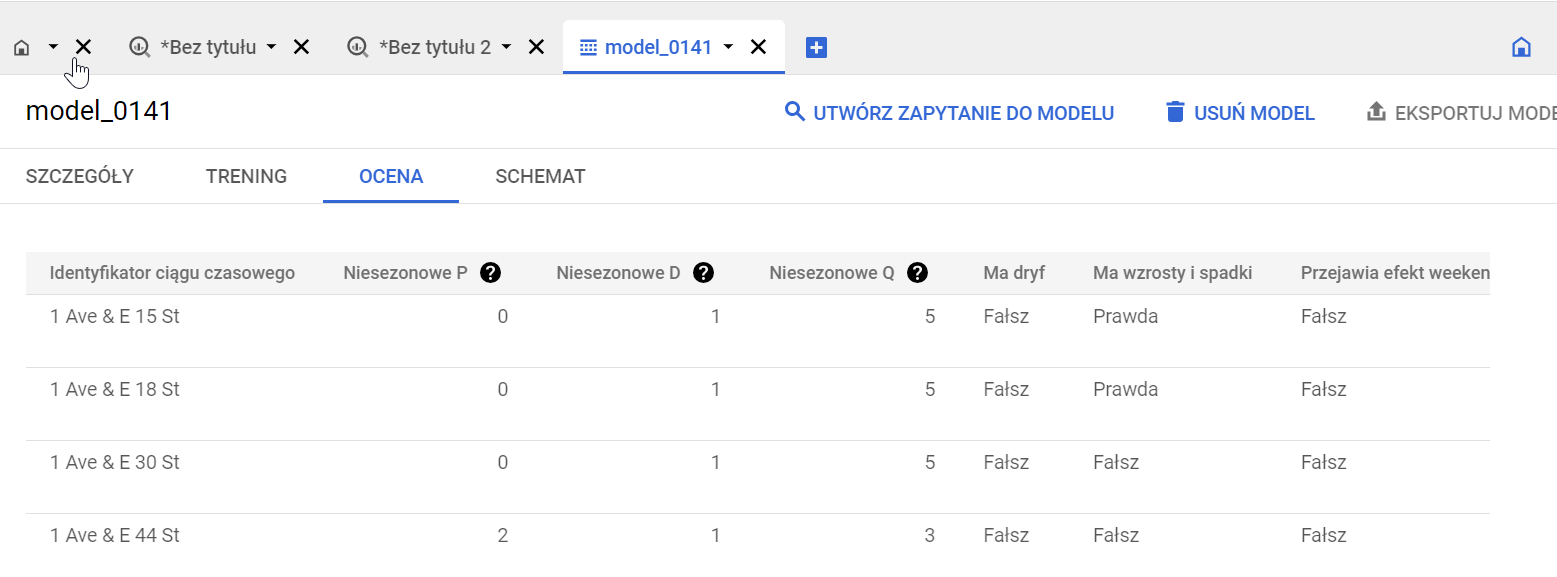

#Oceń dokładność prognozowania dla każdej serii czasowej (Krok 3)

##ML.EVALUATE

* W tym przypadku `pmackowka_us.model_0141` zawiera oba punkty szeregu czasowego sprzed 2016-06-01 i po 2016-06-01. Punkty po 2016-06-01 to podstawowe dane. Punkty sprzed 2016-06-01 służą do uczenia modelu w celu generowania prognoz po tej dacie. Do obliczenia metryk potrzebne są tylko punkty po 2016-06-01. Punkty sprzed 2016-06-01 są ignorowane w obliczaniu metryk.

* Trzeci argument to `STRUCT`, który zawiera dwa parametry. Horyzont wynosi 7, co oznacza, że zapytanie oblicza dokładność prognozowania na podstawie prognozy 7-punktowej.

In [ ]:
%%bigquery

SELECT *
FROM
  ML.EVALUATE(MODEL pmackowka_us.model_0141,
              TABLE pmackowka_us.table_0141,
              STRUCT(7 AS horizon, TRUE AS perform_aggregation))

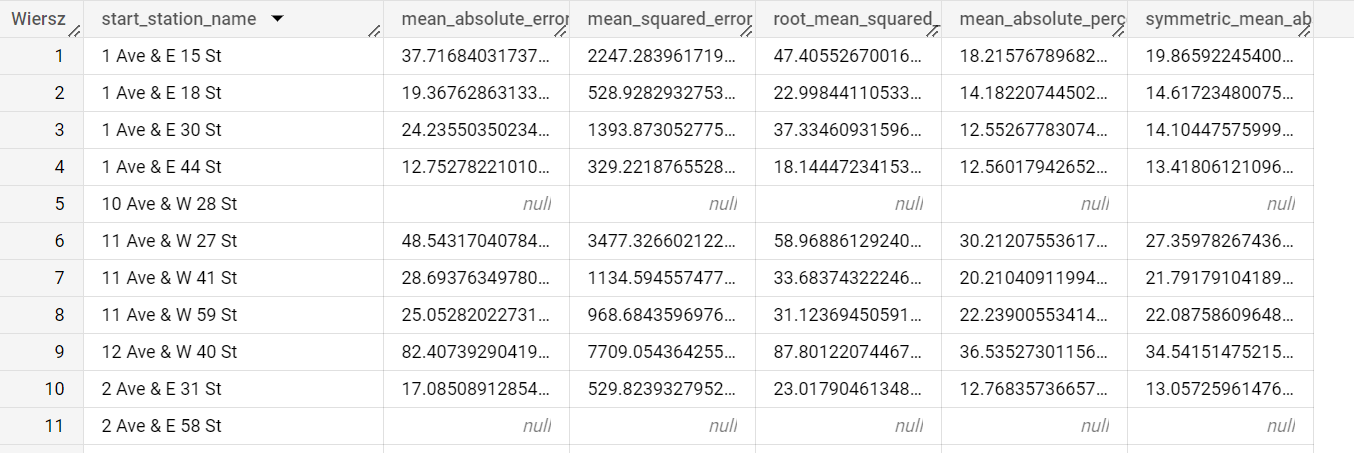

#Oceń ogólną dokładność prognozowania dla wszystkich szeregów czasowych (Krok 4)

In [ ]:
%%bigquery

SELECT
  AVG(mean_absolute_percentage_error) AS MAPE,
  AVG(symmetric_mean_absolute_percentage_error) AS sMAPE
FROM
  ML.EVALUATE(MODEL pmackowka_us.model_0141,
              TABLE pmackowka_us.table_0141,
              STRUCT(7 AS horizon, TRUE AS perform_aggregation))

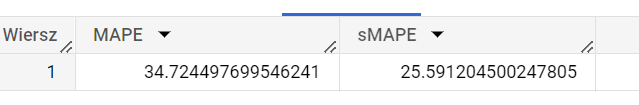

#Prognozuj wiele szeregów czasowych jednocześnie, korzystając z mniejszej przestrzeni poszukiwań hiperparametrów (Krok 5)

##CREATE OR REPLACE MODEL

* To zapytanie zmniejsza się `auto_arima_max_order` z 5 (wartość domyślna) do 2.

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL pmackowka_us.model_0142
OPTIONS
  (model_type = 'ARIMA_PLUS',
   time_series_timestamp_col = 'date',
   time_series_data_col = 'num_trips',
   time_series_id_col = 'start_station_name',
   auto_arima_max_order = 2
  ) AS

SELECT *
FROM pmackowka_us.table_0141
WHERE date < '2016-06-01'

#Oceń dokładność prognozy w oparciu o mniejszą przestrzeń wyszukiwania hiperparametrów (Krok 6)

In [ ]:
%%bigquery

SELECT
  AVG(mean_absolute_percentage_error) AS MAPE,
  AVG(symmetric_mean_absolute_percentage_error) AS sMAPE
FROM
  ML.EVALUATE(MODEL pmackowka_us.model_0142,
              TABLE pmackowka_us.table_0141,
              STRUCT(7 AS horizon, TRUE AS perform_aggregation))

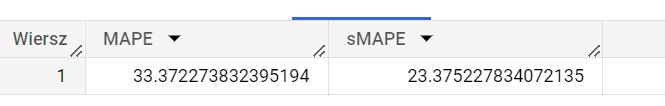

#Prognozuj wiele szeregów czasowych jednocześnie, korzystając z mniejszej przestrzeni wyszukiwania hiperparametrów i inteligentnych strategii szybkiego uczenia (Krok 7)

##CREATE OR REPLACE MODEL

* Opcja `max_time_series_length` ma wartość 30, więc dla każdego z 383 szeregów czasowych do modelowania składnika trendu wykorzystywane jest tylko 30 ostatnich punktów czasowych.

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL pmackowka_us.model_0143
OPTIONS
  (model_type = 'ARIMA_PLUS',
   time_series_timestamp_col = 'date',
   time_series_data_col = 'num_trips',
   time_series_id_col = 'start_station_name',
   auto_arima_max_order = 2,
   max_time_series_length = 30
  ) AS

SELECT *
FROM pmackowka_us.table_0141
WHERE date < '2016-06-01'

#Oceń dokładność prognozowania dla modelu z mniejszą przestrzenią wyszukiwania hiperparametrów i inteligentnymi strategiami szybkiego uczenia (Krok 8)

* Krótko mówiąc, użyłeś mniejszej przestrzeni wyszukiwania hiperparametrów i inteligentnych strategii szybkiego uczenia, aby trenowanie modelu było ponad 20 razy szybsze bez utraty dokładności prognozowania.

In [ ]:
%%bigquery

SELECT
  AVG(mean_absolute_percentage_error) AS MAPE,
  AVG(symmetric_mean_absolute_percentage_error) AS sMAPE
FROM
  ML.EVALUATE(MODEL pmackowka_us.model_0143,
              TABLE pmackowka_us.table_0141,
              STRUCT(7 AS horizon, TRUE AS perform_aggregation))

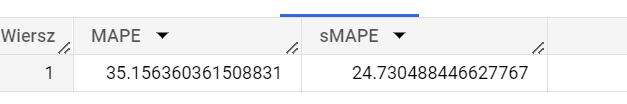

#Prognozuj ponad milion szeregów czasowych (Krok 9)

* Wykonanie zapytania trwa około 1 godziny 16 minut.

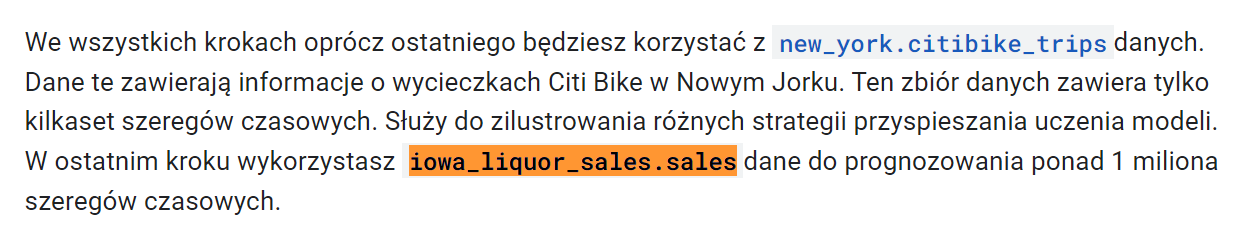

In [ ]:
%%bigquery

SELECT
  store_number,
  item_description,
  date,
  SUM(bottles_sold) as total_bottles_sold
FROM
  `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date BETWEEN DATE("2015-01-01") AND DATE("2021-12-31")
GROUP BY store_number, item_description, date

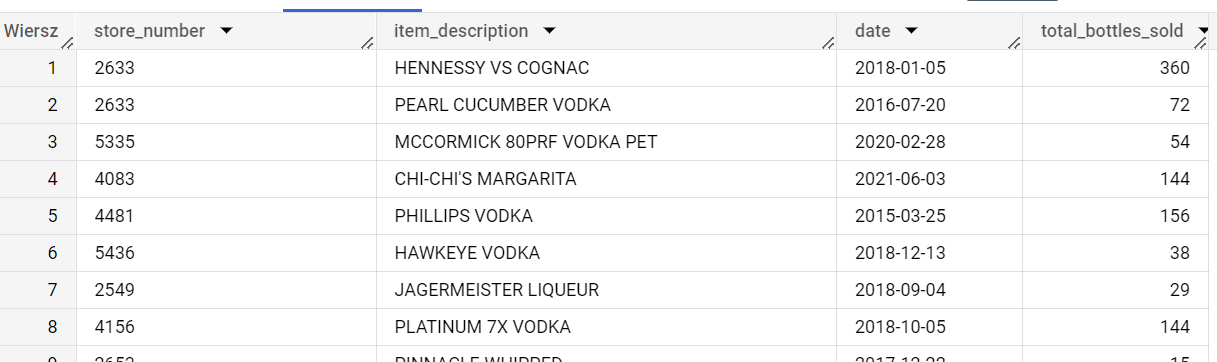

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL
  pmackowka_us.model_0144
OPTIONS(
  MODEL_TYPE = 'ARIMA_PLUS',
  TIME_SERIES_TIMESTAMP_COL = 'date', # The timestamp column name for time series models.
  TIME_SERIES_DATA_COL = 'total_bottles_sold', # The data column name for time series models.

  # Nazwy kolumn identyfikatorów dla modeli szeregów czasowych.
  # Kolumny te są używane, gdy użytkownik chce dopasować i prognozować wiele szeregów czasowych
  # za pomocą jednego zapytania. Różne identyfikatory wskazują różne szeregi czasowe.
  TIME_SERIES_ID_COL = ['store_number', 'item_description'],
  HOLIDAY_REGION = 'US',
  AUTO_ARIMA_MAX_ORDER = 2,

  # Maksymalna liczba punktów czasowych w szeregu czasowym,
  # które można wykorzystać do modelowania składnika trendu szeregu czasowego.
  MAX_TIME_SERIES_LENGTH = 30
) AS


SELECT
  store_number,
  item_description,
  date,
  SUM(bottles_sold) as total_bottles_sold
FROM
  `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date BETWEEN DATE("2015-01-01") AND DATE("2021-12-31")
GROUP BY store_number, item_description, date